In [1]:
batch_size = 4000
lr = 0.002
num_epoch = 500
number_of_features = 41
number_of_class_attack_cat = 10
number_of_class_label = 2
hyper_parameter1=128
hyper_parameter2=64
hyper_parameter3=32
hyper_parameter4=16

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.data.dataset import Dataset
from torch.utils.data import random_split, DataLoader
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt

# GPU OR CPU
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("GPU")
else:
    device = torch.device("cpu")
    print("CPU")

GPU


In [4]:
UNSW_NB15 = pd.read_csv("/content/drive/MyDrive/datasets/UNSW-NB15/UNSW_NB15.csv")

UNSW_NB15.loc[UNSW_NB15["attack_cat"] == "Worms", "attack_cat"] = "G1"
UNSW_NB15.loc[UNSW_NB15["attack_cat"] == "Shellcode", "attack_cat"] = "G1"
UNSW_NB15.loc[UNSW_NB15["attack_cat"] == "Reconnaissance", "attack_cat"] = "G1"
UNSW_NB15.loc[UNSW_NB15["attack_cat"] == "Exploits", "attack_cat"] = "G1"

indexAge = UNSW_NB15[ (UNSW_NB15['attack_cat'] == 'Normal') ].index
UNSW_NB15.drop(indexAge , inplace=True)

UNSW_NB15_category = UNSW_NB15.copy()
UNSW_NB15_label = UNSW_NB15.copy()

UNSW_NB15

,Unnamed: 0,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
47911,47911,47912,0.000009,ddp,-,INT,2,0,200,0,...,1,4,0,0,0,2,4,0,Backdoor,1
47912,47912,47913,0.000009,ipv6-frag,-,INT,2,0,200,0,...,2,7,0,0,0,2,7,0,Backdoor,1
47913,47913,47914,0.000009,cftp,-,INT,2,0,200,0,...,1,6,0,0,0,1,6,0,Backdoor,1
47914,47914,47915,0.000003,wsn,-,INT,2,0,200,0,...,2,7,0,0,0,2,6,0,Backdoor,1
47915,47915,47916,0.000008,pvp,-,INT,2,0,200,0,...,1,4,0,0,0,11,4,0,Backdoor,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241188,241188,65848,0.000012,udp,-,INT,2,0,1510,0,...,1,1,0,0,0,1,5,0,Fuzzers,1
241189,241189,65849,20.542910,udp,-,INT,4,0,1216,0,...,1,1,0,0,0,1,6,0,Fuzzers,1
241190,241190,65850,20.542910,udp,-,INT,4,0,1216,0,...,1,1,0,0,0,1,6,0,Fuzzers,1
241191,241191,65851,0.627022,tcp,-,FIN,10,6,590,268,...,1,1,0,0,0,1,5,0,Fuzzers,1


In [5]:
class DataSet_UNSWNB15_attack_cat(Dataset):

    def __init__(self,csv_df):
        df = csv_df
        print(df.attack_cat.value_counts().sort_values().plot(kind = "barh"))
        print(df['attack_cat'].value_counts())

        # preprocceing
        df.drop(['id',"Unnamed: 0","service","label"], axis=1, inplace=True)        
        cols = ['attack_cat' ,'proto' ,'state']
        df[cols] = df[cols].apply(LabelEncoder().fit_transform)
        print(df['attack_cat'].value_counts())

        self.data_array = df.values
        self.x = self.data_array[:, :41]
        self.y = self.data_array[:, 41]
      
        # normalaized data
        scaler = preprocessing.StandardScaler().fit(self.x)
        self.x = scaler.transform(self.x)

        self.x = torch.tensor(self.x).float()
        self.y = torch.tensor(self.y).long()

    def __len__(self):
        return len(self.data_array)

    def __getitem__(self, item):
        sample = (self.x[item, :], self.y[item])
        return sample

        
class DataSet_UNSWNB15_label(Dataset):

    def __init__(self, csv_path):
        df = csv_path
        print(df.label.value_counts().sort_values().plot(kind = "pie"))

        # preprocceing
        df.drop(['id',"Unnamed: 0","service","attack_cat"], axis=1, inplace=True)
        cols = ['proto' ,'state']
        df[cols] = df[cols].apply(LabelEncoder().fit_transform)

        self.data_array = df.values
        self.x = self.data_array[:, :41]
        self.y = self.data_array[:, 41]
        
        # normalaized data
        scaler = preprocessing.StandardScaler().fit(self.x)
        self.x = scaler.transform(self.x)

        self.x = torch.tensor(self.x).float()
        self.y = torch.tensor(self.y).long()

    def __len__(self):
        return len(self.data_array)

    def __getitem__(self, item):
        sample = (self.x[item, :], self.y[item])
        return sample

Axes(0.125,0.11;0.775x0.77)
G1          60197
Generic     58871
Fuzzers     24246
DoS         16353
Analysis     2677
Backdoor     2329
Name: attack_cat, dtype: int64
4    60197
5    58871
3    24246
2    16353
0     2677
1     2329
Name: attack_cat, dtype: int64


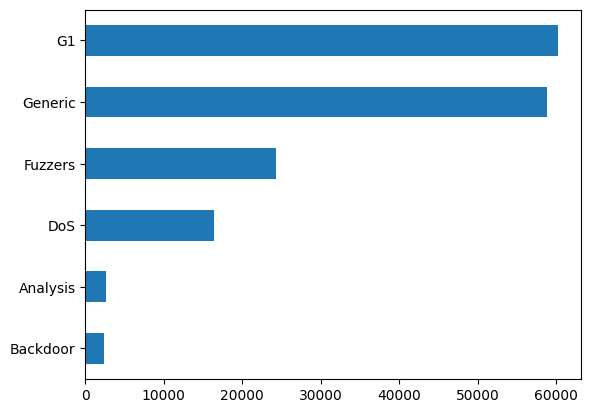

In [6]:
dataset_attack_cat = DataSet_UNSWNB15_attack_cat(UNSW_NB15_category)

number_of_test = int(len(dataset_attack_cat)*0.3)
number_of_train = len(dataset_attack_cat) - int(len(dataset_attack_cat)*0.3)
train_attack_cat ,test_attack_cat = random_split(dataset=dataset_attack_cat, lengths=[number_of_train,number_of_test])

train_attack_cat_dataloader = DataLoader(dataset=train_attack_cat ,batch_size=batch_size ,shuffle=True)
test_attack_cat_dataloader = DataLoader(dataset=test_attack_cat ,batch_size=batch_size ,shuffle=True)

Axes(0.22375,0.11;0.5775x0.77)


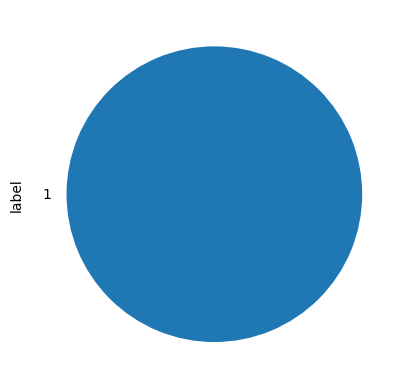

In [7]:
dataset_label = DataSet_UNSWNB15_label(UNSW_NB15_label)
number_of_test = int(len(dataset_label)*0.3)
number_of_train = len(dataset_label) - int(len(dataset_label)*0.3)
train_label ,test_label = random_split(dataset=dataset_label, lengths=[number_of_train,number_of_test])

train_label_dataloader = DataLoader(dataset=train_label ,batch_size=batch_size ,shuffle=True)
test_label_dataloader = DataLoader(dataset=test_label ,batch_size=batch_size ,shuffle=True)

In [8]:
class Model_Attack_Cat(nn.Module):

    def __init__(self):
        super(Model_Attack_Cat, self).__init__()

        self.layers = nn.Sequential(
        nn.Linear(number_of_features, hyper_parameter1),
        nn.Tanh(),
        nn.Linear(hyper_parameter1, hyper_parameter2),
        nn.Tanh(),
        nn.Linear(hyper_parameter2, hyper_parameter3),
        nn.Sigmoid(),
        nn.Linear(hyper_parameter3, hyper_parameter4),
        nn.Sigmoid(),
        nn.Linear(hyper_parameter4,number_of_class_attack_cat)
        )

    def forward(self,x):
        return self.layers(x)

class Model_Label(nn.Module):

    def __init__(self):
        super(Model_Label, self).__init__()

        self.layers = nn.Sequential(
        nn.Linear(number_of_features, hyper_parameter1),
        nn.Tanh(),
        nn.Linear(hyper_parameter1, hyper_parameter2),
        nn.Tanh(),
        nn.Linear(hyper_parameter2, hyper_parameter3),
        nn.Sigmoid(),
        nn.Linear(hyper_parameter3, hyper_parameter4),
        nn.Sigmoid(),
        nn.Linear(hyper_parameter4,number_of_class_label)
        )
      

    def forward(self,x):
         return self.layers(x)

In [9]:
my_model_attack = Model_Attack_Cat().to(device=device)
my_model_attack

Model_Attack_Cat(
  (layers): Sequential(
    (0): Linear(in_features=41, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): Sigmoid()
    (8): Linear(in_features=16, out_features=10, bias=True)
  )
)

In [10]:
loss_fn1 = nn.CrossEntropyLoss()
loss_fn2 = nn.CrossEntropyLoss()
optimizer1 = opt.Adam(params=my_model_attack.parameters(),lr=lr)


In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# **train attack cat**

In [12]:
loss_plot = list()

for epoch in range(num_epoch+1):

    for batch_x, batch_y in train_attack_cat_dataloader:

        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer1.zero_grad()
        loss1 = loss_fn1(my_model_attack(batch_x),batch_y)
        loss1.backward()
        optimizer1.step()

    if epoch % 50 == 0:
        print("loss : %.4f" % (loss1.item()))
        loss_plot.append(loss1.item())



loss : 1.7074
loss : 0.4846
loss : 0.4460
loss : 0.4289
loss : 0.4131
loss : 0.4012
loss : 0.3920
loss : 0.3875
loss : 0.3801
loss : 0.3937
loss : 0.3787


# **test attack cat**

In [13]:
correct = 0
y_test, yhat = list(), list()

for batch_x, labl in test_attack_cat_dataloader:
  
    batch_x = batch_x.to(device)
    labl = labl.to(device)
  
    out = my_model_attack(batch_x)
    _,predicted = torch.max(out,1)
    correct += torch.sum(predicted == labl)
    print(batch_x)
    print(out)
    print(labl)
    print(predicted)
    print("--------------")
    
    for i in labl.cpu().detach().numpy():
        y_test.append(i)
    for i in predicted.cpu().detach().numpy():
        yhat.append(i)


print("acc : %.2f" % (100.*correct / len(test_attack_cat)),end="")
print("%")

tensor([[-0.2075,  0.4183,  0.6846,  ..., -0.5550, -0.0921,  0.0000],
        [-0.2075,  0.4183,  0.6846,  ...,  1.7090, -0.8152,  0.0000],
        [-0.2075,  0.4183,  0.6846,  ...,  2.4293,  0.3096,  0.0000],
        ...,
        [-0.2075, -0.9488,  0.6846,  ..., -0.6579, -0.5742,  0.0000],
        [-0.1082,  0.1254, -1.2792,  ..., -0.6579, -0.5742,  0.0000],
        [-0.2075,  0.4183,  0.6846,  ...,  1.1944,  1.7558,  0.0000]],
       device='cuda:0')
tensor([[ -1.8612,  -3.3451,  -2.8667,  ..., -10.0412,  -9.9515, -10.1542],
        [ -2.2292,  -3.3844,  -2.1638,  ..., -12.2598, -12.1604, -12.4586],
        [ -5.9640,  -2.4154,   0.5205,  ..., -10.0023,  -9.9811, -10.1833],
        ...,
        [  0.6744,   0.5436,   2.6004,  ..., -11.1235, -10.9783, -11.2607],
        [  1.9275,  -0.7827,  -1.0678,  ..., -10.6739, -10.5249, -10.8347],
        [ -3.6583,  -7.4429,  -1.7452,  ...,  -8.0407,  -7.7412,  -8.0809]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([3, 4, 3,  ...,

Confusion matrix, without normalization
[[17384   251    42    28     3     2]
 [   98 17047   506   342    13    23]
 [   13  1000  6183    26     1     3]
 [   33  4311   166   419     4     8]
 [    5   537   118    22    36     0]
 [    0   508   117    14     0   138]]


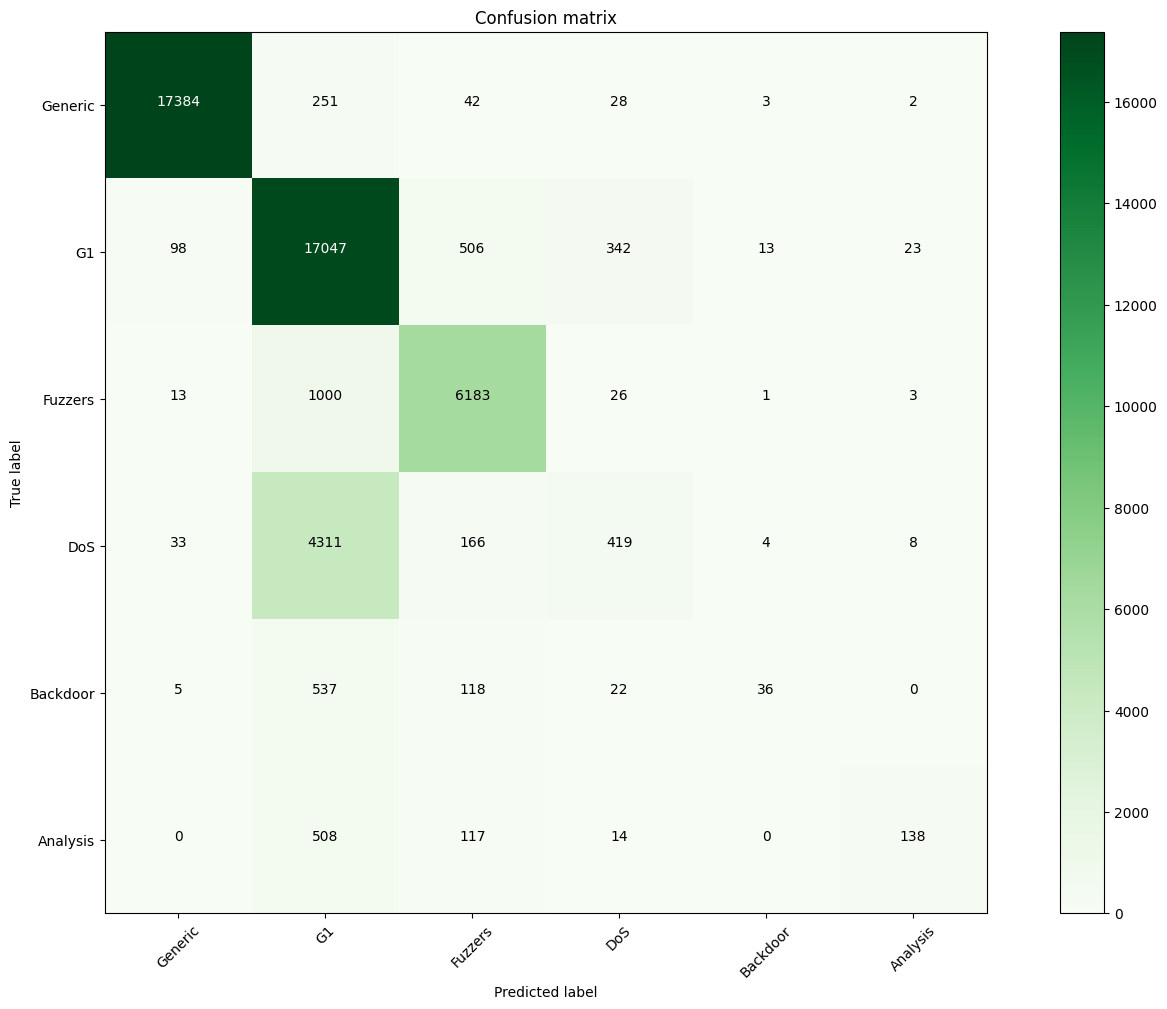

In [19]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[5,4,3,2,1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure(figsize=(15,10))
plot_confusion_matrix(cnf_matrix, classes=['Generic','G1','Fuzzers','DoS','Backdoor','Analysis'],normalize= False,  title='Confusion matrix')

In [15]:
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.79      0.18      0.29       777
           1       0.63      0.05      0.09       718
           2       0.49      0.08      0.14      4941
           3       0.87      0.86      0.86      7226
           4       0.72      0.95      0.82     18029
           5       0.99      0.98      0.99     17710

    accuracy                           0.83     49401
   macro avg       0.75      0.52      0.53     49401
weighted avg       0.82      0.83      0.80     49401

